In [1]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sp

# Load the raw collection
s = np.fromfile(open("rawData2"), dtype=np.complex64)

# Notes from Matthew
Fs = 1e6
Fc = 433946924

# Setup a time axis
t = np.arange(s.size) / Fs

In [9]:
def filterSignal(s, timeframe, Fs):
    # Low =-pass filter the data
    h = sp.firwin(numtaps=101, cutoff=1, nyq=Fs/2)
    s_filtered = np.abs(sp.lfilter(h, 1.0, s[timeframe]))
    return s_filtered

def getStartTime(s):
    # Find the start of the first data chunk
    start = 0
    for i, item in enumerate(s):
        if(np.abs(item) > 0.05):
            start = i
            break
    if(start == 0):
        # no signal found
        return -1
    else:
        return start

def signal_to_data(s_filtered):
    # print("Total Signal Length: ", s_filtered.size)
    # First find the mean amplitude of the filtered data signal
    avg = sum(s_filtered) / s_filtered.size
    # Anything that is below the mean is 0, and anything above is 1
    scaled = s_filtered.copy()
    for i, item in enumerate(scaled):
        if item < avg:
            scaled[i] = 0
        else:
            scaled[i] = 1
    # Find the duration of each peak and place them into an array
    durations = []
    bits = []
    prevVal = scaled[0]
    duration = 0
    for i in range(scaled.size):
        if(scaled[i] == prevVal):
            duration = duration + 1
        else:
            durations.append(duration)
            if(duration > 580):
                bits.append(bool(prevVal))
                bits.append(bool(prevVal))
                bits.append(bool(prevVal))
            elif(duration > 380):
                bits.append(bool(prevVal))
                bits.append(bool(prevVal))
            else:
                bits.append(bool(prevVal))
            duration = 0 # reset the duration "timer"
        prevVal = scaled[i]

    # print out the durations array
    # print(durations)
    
    # traverse the durations array and decode it (if short to long, 0; if long to short, 1) (ignore preamble)
    decoded = []
    
    # convert the bits into a string
    byteStr = ""
    for b in bits:
        byteStr += str(int(b))
        
    # find the sync pulses
    sync = "111000111000111000111000"
    startSync1 = byteStr.find(sync)
    bits = bits[startSync1 + len(sync) : ]
    
    # get the actual data from the remaining 56 bits (1st signal)
    for i in range(2, 2 + (56 * 3)):
        if(bits[i - 2] == 1 and bits[i - 1] == 1 and bits[i] == 0):
            # 400 high then 200 low, so bit of 1
            decoded.append(1)
        elif(bits[i - 2] == 1 and bits[i - 1] == 0 and bits[i] == 0):
            # 200 high then 400 low, so bit of 0
            decoded.append(0)
    # print(len(decoded))
    print(decoded)
    
    decodedStr = ""
    for b in decoded:
        decodedStr += str(int(b))
    
    return decodedStr

def compare_byteStrings(b1, b2, b3):
    return b1 == b2 and b2 == b3

def getFahrenheit(byteStr):
    # isolate the temperature bits from the data string
    tempStr = byteStr[33:40] + byteStr[41:48]
    print(tempStr)
    
    # get the decimal number corresponding to this binary num
    num = 0
    for i, item in enumerate(tempStr):
        num += int(item) * pow(2,len(tempStr) - i - 1)
        
    # using the linear regression done in testing, get the actual temperature
    return -152.923 + (0.184 * num)

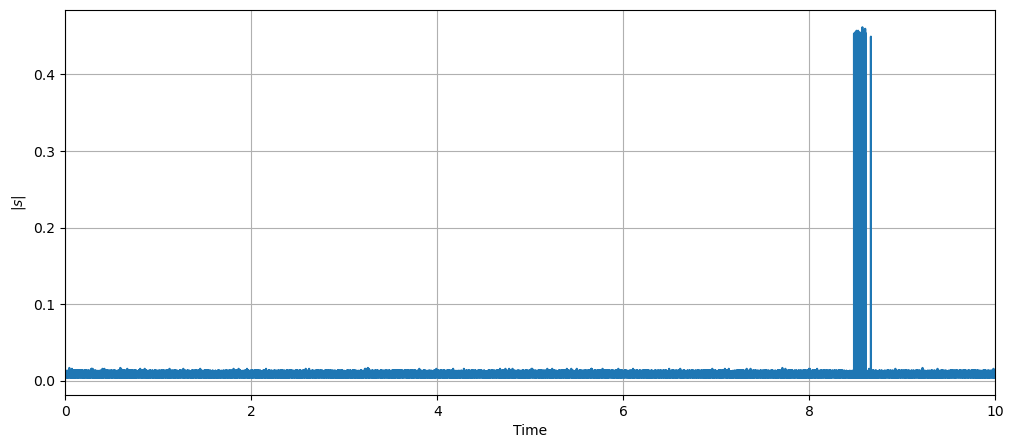

In [3]:
plt.figure(figsize=(12,5))
plt.plot(t, np.abs(s))
plt.xlabel('Time')
plt.ylabel('$|s|$')
plt.xlim(0,10)
plt.grid()
plt.show()

In [4]:
startTime = (getStartTime(s)/Fs) - 0.002
print(startTime)
timeframe = np.where(np.logical_and(t>=startTime, t<=startTime+0.15))[0]

8.477485999999999


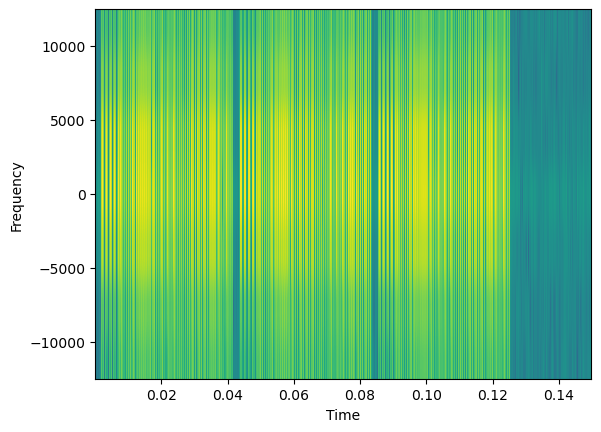

In [5]:
plt.specgram(s[timeframe], Fs=Fs)
plt.ylim(-12500,12500)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [10]:
s_filtered1 = filterSignal(s, timeframe, Fs)
b1 = signal_to_data(s_filtered1)
print(b1)
print(getFahrenheit(b1))

[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]
11000001011111110100010010010000000010010010011101000100
00010010100111
66.221
